In [1]:
import numpy as np
import sys
import scipy.stats as sps
from hmmlearn import hmm
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Скрытые марковские модели
Зададим некоторую скрытую марковскую модель

In [61]:
# Объявление скрытой марковской модели с двумя скрытыми состояниями, 
# в которой предполагается, что каждое состояние может генерировать 
# гауссовский случайный вектор с произвольной матрицей ковариаций.
# Используется метод Витерби.
# Поставьте 'map', чтобы использовать метод forward-backward.
model = hmm.GaussianHMM(n_components=2, covariance_type='full', 
                        algorithm='viterbi')

# Параметры марковской цепи - начальное состояние и матрица переходных вероятностей
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.07, 0.93]])

# Параметры условных распределений Y_j при условии X_j - вектора средних и
# матрица ковариаций по количеству состояний. Поскольку в данном случае
# распределения одномерные, ниже записаны два вектора размерности 1
# и две матрицы размерности 1x1
model.means_ = np.array([[0.0], [3.0]])
model.covars_ = np.array([[[1]], [[1]]])

Сгенерируем некоторую последовательность с помощью определенной выше модели.

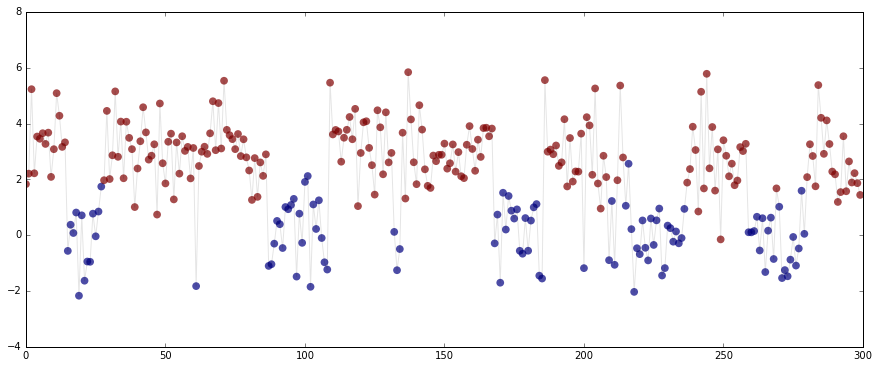

In [62]:
size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.show()

На основе сгенерированной выше последовательности оценим параметры ("обучим") скрытой марковской модели и значения скрытых состояний.

In [63]:
# Объявление скрытой марковской модели, в которой при оценке параметров 
# будет производиться не более n_iter итераций EM-алгоритма.
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, algorithm='viterbi')

# Оценка параметров ("обучение")
remodel.fit(Y)  

# Оценка ("предсказание") значений скрытых состояний
X_predicted = remodel.predict(Y)

In [64]:
# # Состояния определяются с точностью до их перестановки.
# Найдем перестановку с минимальным числом ошибок
def get_transp(n):
    if n == 1:
        return [[0]]
    prev = get_transp(n-1)
    prev = [x + [n-1] for x in prev]
    ans = []
    for i in range(n):
        for x in prev:
            y = list(x)
            y[n-1] = y[i]
            y[i] = n-1
            ans.append(y)
    return ans
        

def find_min_transp(X,X_predicted,n):
    tr = get_transp(n)
    minn = []
    for t in tr:
        X_mod = [t[i] for i in X_predicted]
        minn.append((X != X_mod).sum())
    return tr[np.argmin(np.array(minn))]

def correct_order(X, X_predicted, n):
    min_tr = find_min_transp(X, X_predicted, n)
    return [min_tr[i] for i in X_predicted]

Теперь изобразим полученные результаты:

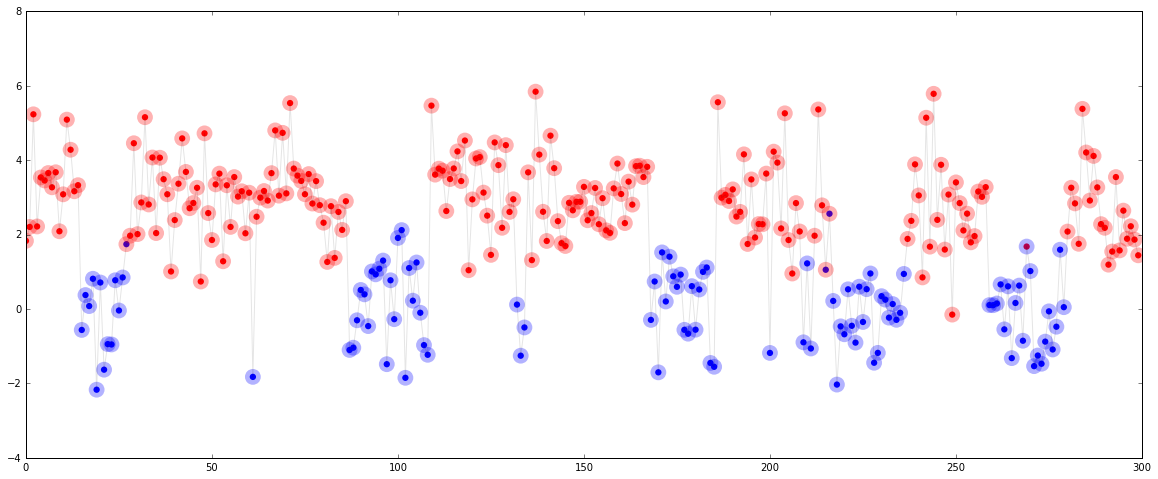

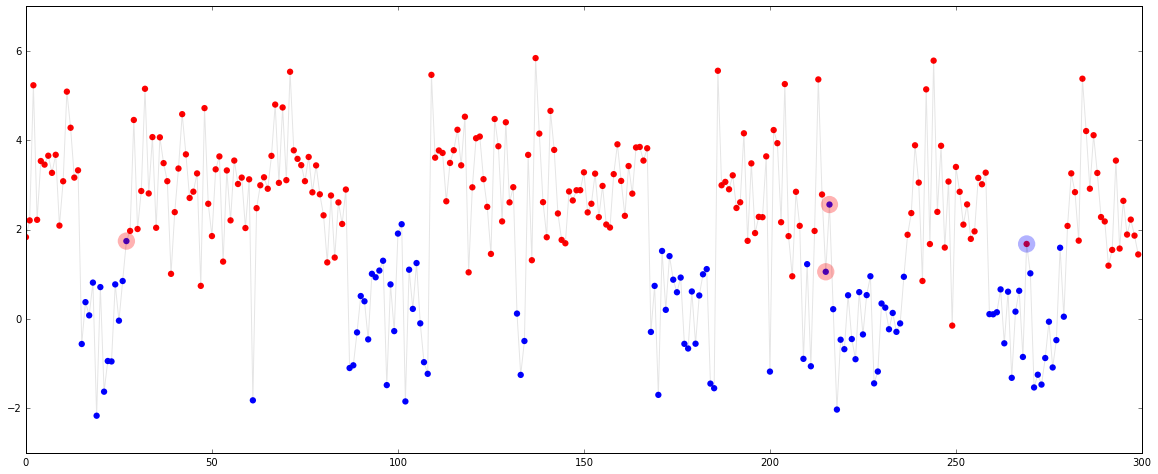

errors rate: 1.0 %


In [65]:
colors = np.array(['blue', 'red', 'orange'])

X_predicted = correct_order(X, X_predicted, 2)

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X_predicted)], 
            lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 0][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()
print('errors rate: ' + str(round((X != X_predicted).sum()/len(X) * 100)) + ' %')

На обоих графиках непрозразными маленькими кружочками отмечена исходная последовательность. Полупрозрачными большими кружочками отмечены оценки значений скрытых состояний. На первом графике отмечены все такие точки, на втором только те из них, оценка значения скрытого состояния которых получилась неправильно.

Как понять, что EM-алгоритм сошелся? Для этого нужно посчитать значение некоторого функционала, который является чересчур громоздким. Поэтому мы всего лишь посмотрим на его значения.

In [66]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

Теперь можно загрузить значения и построить график:

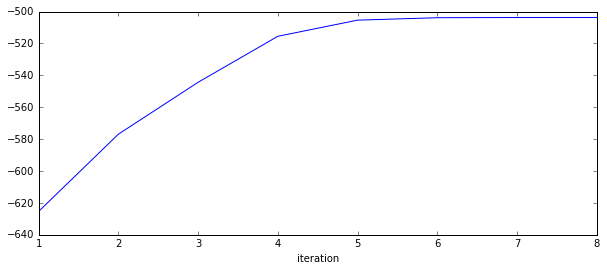

In [67]:
values = np.loadtxt('./est_values.txt')
plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.show()

Выполним те же операции для следующих двух случаев

a) скрытая марковская цепь имеет три скрытых состояния;

b) распределение $Y_j$ при условии $X_j$ является двумерным гауссовским.

### a
Возьмем следущие матрицу переходов и начальное состояние: 
$ P =  \left( 
 \begin{matrix}
  \frac{3}{7} & \frac{3}{7} & \frac{1}{7} \\
  \frac{1}{11} & \frac{2}{11} & \frac{8}{11} \\
  \frac{1}{11} & \frac{4}{11} & \frac{6}{11}
 \end{matrix}
 \right), \quad \Pi^{(0)} = \left(\frac{1}{3}, \frac{1}{3}, \frac{1}{3} \right)$

In [68]:
model = hmm.GaussianHMM(n_components=3, covariance_type='full', 
                        algorithm='viterbi')

model.startprob_ = np.array([1/3, 1/3, 1/3])
model.transmat_ = np.array([[3/7, 3/7, 1/7],
                            [1/11, 2/11, 8/11],
                            [1/11, 4/11, 6/11]])

model.means_ = np.array([[0.0], [3.0], [6.0]])
model.covars_ = np.array([[[1]], [[1]], [[1]]])

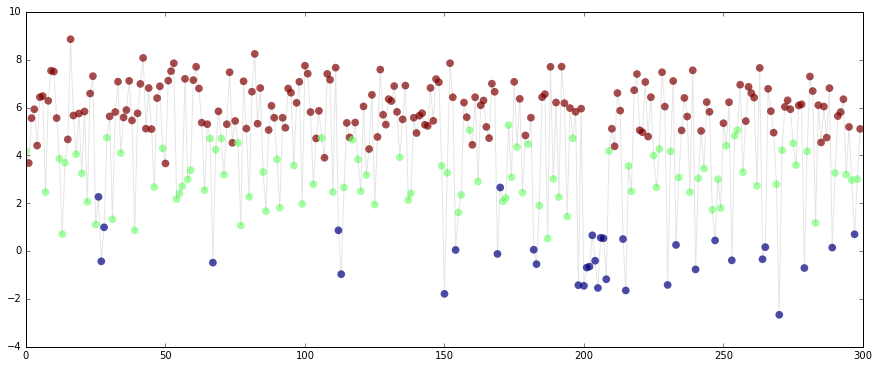

In [69]:
size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.show()

In [70]:
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full",
                          n_iter=100, algorithm='viterbi')
# Оценка параметров ("обучение")
remodel.fit(Y)  
# Оценка ("предсказание") значений скрытых состояний
X_predicted = remodel.predict(Y)

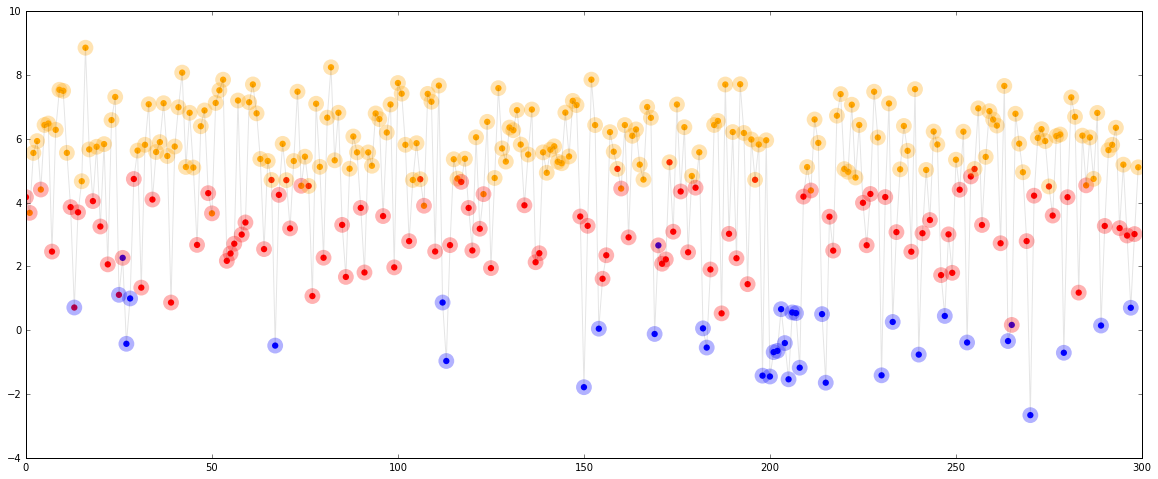

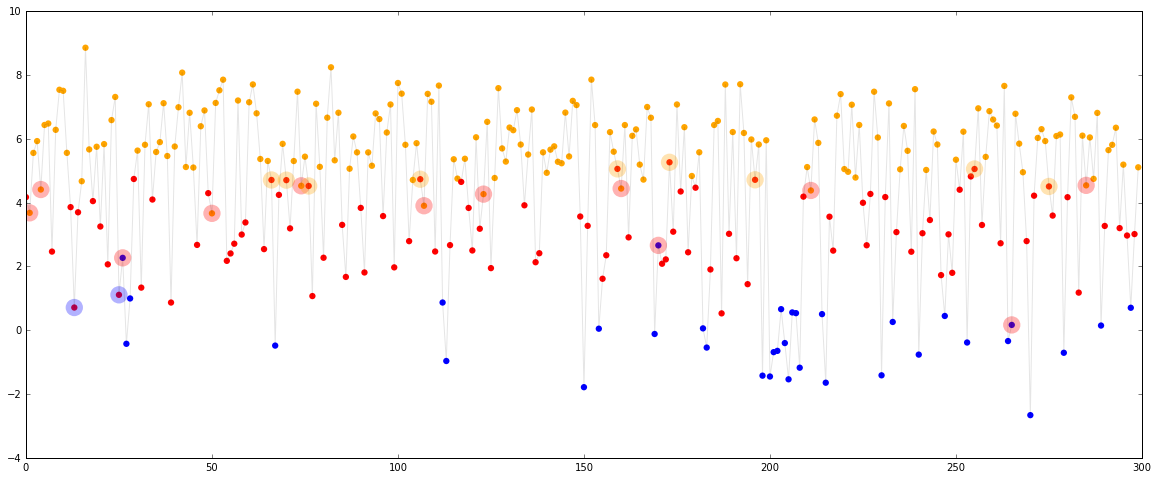

errors rate: 8.0 %


In [71]:
colors = np.array(['blue', 'red', 'orange'])

# Состояния определяются с точностью до их перестановки.
# При необходимости меняем местами состояния
X_predicted = correct_order(X, X_predicted, 3)

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X_predicted)], 
            lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 0][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()
print('errors rate: ' + str(round((X != X_predicted).sum()/len(X) * 100)) + ' %')

In [72]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

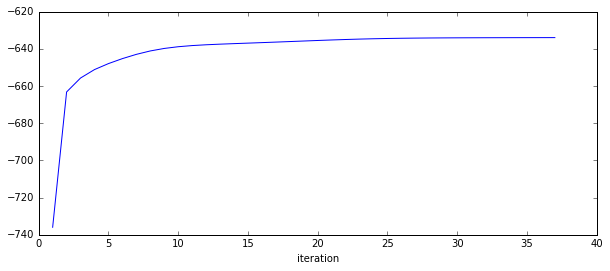

In [73]:
values = np.loadtxt('./est_values.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.show()

### b
возьмем  $P, \Pi^{(0)}$ как в первом примере

In [74]:
model = hmm.GaussianHMM(n_components=3, covariance_type='full', 
                        algorithm='viterbi')

model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.07, 0.93]])

model.means_ = np.array([[0.0, 0.0], [2.0, 2.0]])
model.covars_ = np.array([[[1, 0.5], [0.5, 1]], [[1, 0.5], [0.5, 1]]])

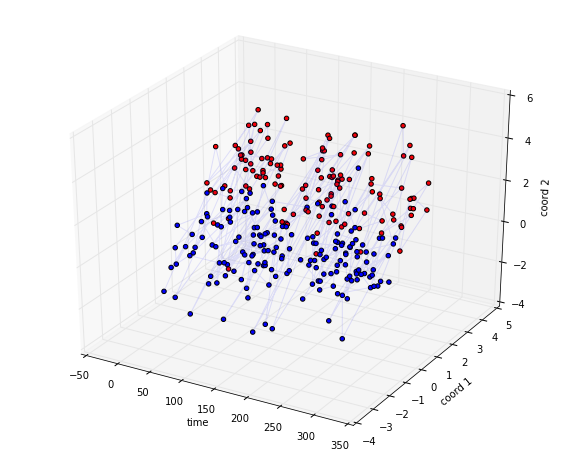

In [75]:
size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
ax.scatter(np.arange(size), [y[0] for y in Y], [y[1] for y in Y], c = colors[np.array(X)], alpha = 1)
ax.plot(np.arange(size), [y[0] for y in Y], [y[1] for y in Y], alpha = 0.1)
# plt.figure(figsize=(15, 6))
# plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
# plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), lw=0, s=60, alpha=0.7)
ax.set_xlabel('time')
ax.set_ylabel('coord 1')
ax.set_zlabel('coord 2')
plt.show()

In [76]:
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, algorithm='viterbi')
# Оценка параметров ("обучение")
remodel.fit(Y)  
# Оценка ("предсказание") значений скрытых состояний
X_predicted = remodel.predict(Y)

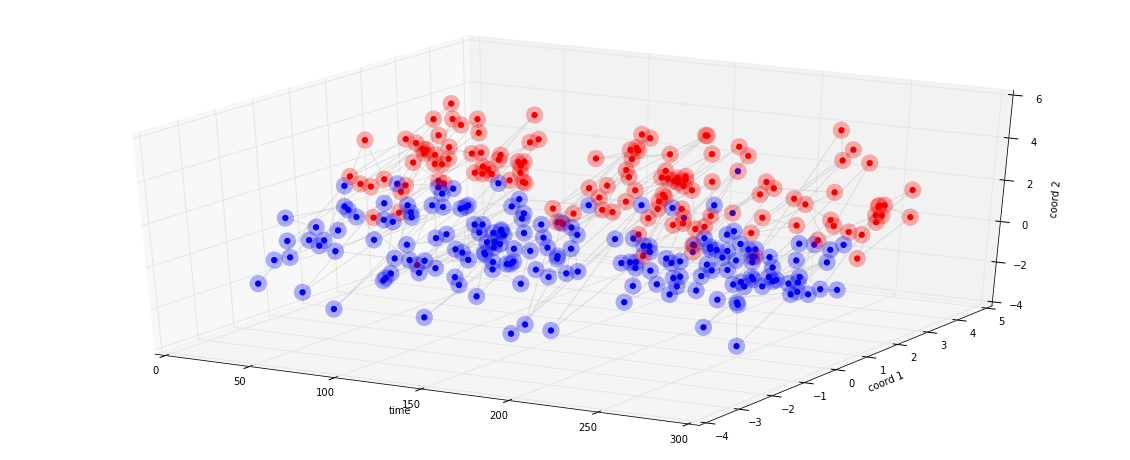

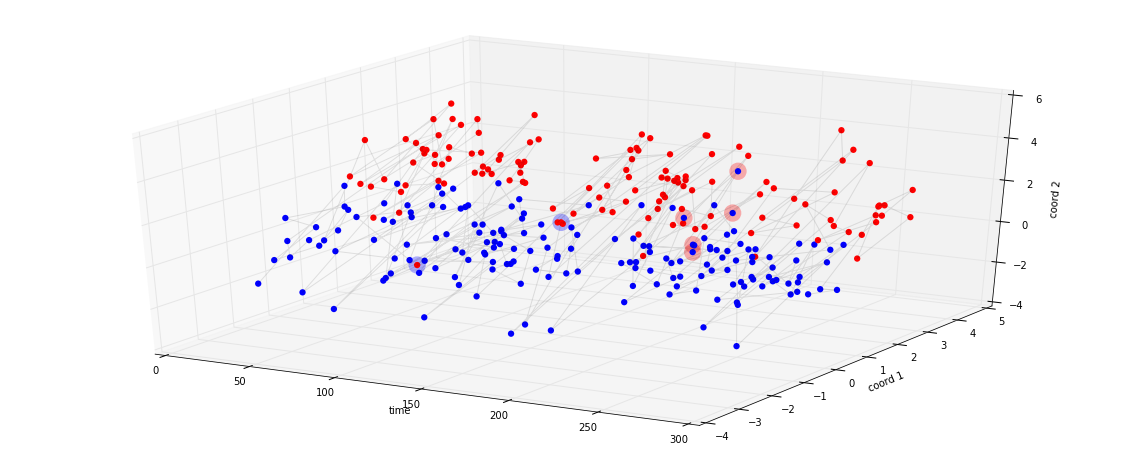

errors rate: 2.0 %


In [77]:
colors = np.array(['blue', 'red', 'orange'])

# Состояния определяются с точностью до их перестановки.
# При необходимости меняем местами состояния
X_predicted = correct_order(X, X_predicted, 2)

fig = plt.figure(figsize=(20, 8))
ax = fig.gca(projection='3d')
ax.plot(np.arange(size), [y[0] for y in Y], [y[1] for y in Y], color='black', alpha=0.1)
ax.scatter(np.arange(size), [y[0] for y in Y], [y[1] for y in Y], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
ax.scatter(np.arange(size),[y[0] for y in Y], [y[1] for y in Y], 
            c=colors[np.array(X_predicted)], 
            lw=0, s=300, alpha=0.3)
ax.set_xlabel('time')
ax.set_ylabel('coord 1')
ax.set_zlabel('coord 2')
plt.xlim((0, size))
plt.show()

fig=plt.figure(figsize=(20, 8))
ax = fig.gca(projection='3d')
ax.plot(np.arange(size), [y[0] for y in Y], [y[1] for y in Y], color='black', alpha=0.1)
ax.scatter(np.arange(size), [y[0] for y in Y], [y[1] for y in Y], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
ax.scatter(np.arange(size)[X != X_predicted],[y[0] for y in Y[X != X_predicted]], [y[1] for y in Y[X != X_predicted]], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
ax.set_xlabel('time')
ax.set_ylabel('coord 1')
ax.set_zlabel('coord 2')
plt.xlim((0, size))
plt.show()
print('errors rate: ' + str(round((X != X_predicted).sum()/len(X) * 100)) + ' %')

In [78]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

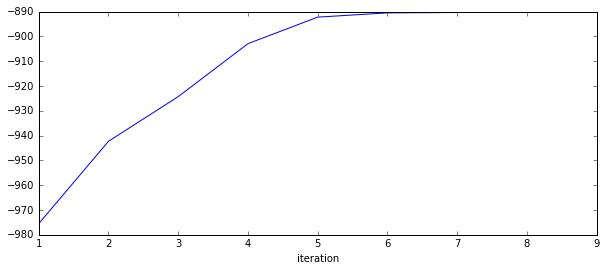

In [79]:
values = np.loadtxt('./est_values.txt')
plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.show()

Как видно, в рассматриваемых случаях(когда $EY_i$ отличаются не менее чем на $2\sigma$ друг от друга), 
все распознается очень хорошо(порядок ошибки 5-10%). 
Для сходимости функционала достаточно << 100 итераций.

## 2 Картинки

In [10]:
def cut_image(image, n, m):
    ''' Разрезает изображение на блоки размера n на m, вытягивая их в вектор'''
    
    N, M, K = image.shape  # высота, ширина, глубина (3 для RGG, 4 для RGBa)
              # ставим высоту последним измерением и разбиваем по нему
    X = image.transpose((1, 2, 0)).reshape((M, K, N / n, n)) \
            .transpose((1, 2, 3, 0)).reshape((K, N / n, n, M / m, m)) \
            .transpose((1, 3, 2, 4, 0)).reshape(((N * M) / (n * m), n * m * K))
            
    return X


def recat_image(X, N, M, K, n, m):
    ''' Собирает разрезанное ранее изображение из блоков n на m'''
    # Тут такая же магия
    return X.reshape((N / n, M / m, n, m, K)).transpose((1, 3, 4, 0, 2)) \
             .reshape((M / m, m, K, N)).transpose((3, 2, 0, 1)) \
             .reshape((N, K, M)).transpose((0, 2, 1))


def est_gauss(X):
    ''' Оценка параметров многомерного гауссовского распределения с помощью ОМП
    '''
    
    mean = X.mean(axis=0)
    X_centered = np.matrix(X - mean[np.newaxis, :])
    cov_matrix = np.array(X_centered.T * X_centered/ X.shape[0])
#     print(cov_matrix.shape)
    for i in range(len(cov_matrix)):
        cov_matrix[i][i] += 1e-4

    return mean, cov_matrix

#  восстановление класса: вода, лес, иное для недокрашенных клеток 
# (размеченная вручную карта строго говоря не полностью состоит только из 3 цветов)
def clustering(image):
    classes = [[1,0,0],[0,1,0],[0,0,1]]
    prev = (0,0,1)
    clustered = []
    for i in range(len(image)):
        for j in range(len(image[i])//3):
            cur = (image[i][3*j],image[i][3*j+1],image[i][3*j+2])
            if cur != (1,0,0) and cur != (0,1,0) and cur != (0,0,1):
                cur = prev
                image[i][3*j],image[i][3*j+1],image[i][3*j+2] = prev[0], prev[1], prev[2]
            prev = cur
            
def get_classes(target):
    classes = []
    for l in target:
        summ = [0,0,0]
        for i in range(len(l)//3):
            summ += l[3*i:3*i+3]
        classes.append(np.argmax(np.array(summ)))
    return np.array(classes)

In [11]:
%%time
image = plt.imread('train_images/3.png')
shape = image.shape
x,y = shape[0],shape[1]
x = (x//25)*25
y = (y//25)*25
image = image[:x, :y, :]  # обрезка краев, для целочисленного деления
Y = cut_image(image, 25, 25)   # при разбиении на блоки
# Y = clustering(Y)
print(Y.shape)

target = plt.imread('train_images/3_tr.png')
target = target[:x, :y, :]
target = cut_image(target, 25, 25)
clustering(target) 
X = get_classes(target)
# X = (target.sum(axis=1) > target.shape[1] / 2).astype(int)  # бинаризация меток
print(target.shape, X.shape)

# print(len(X))

(3956, 1875)
(3956, 1875) (3956,)
CPU times: user 25.5 s, sys: 152 ms, total: 25.7 s
Wall time: 25.9 s


/Users/sergmiller/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


В качестве переходных вероятностей возьмем эмпирические переходные вероятности: 
$p_{ij} = \frac{\sum_{k=0}^{n-1} I(X_k = i \& X_{k+1} = j)}{\sum_{k=0}^{n-1} I(X_k = i)}$

In [12]:
means, covars = [0, 0, 0], [0, 0, 0]
means[0], covars[0] = est_gauss(Y[X == 0])
means[1], covars[1] = est_gauss(Y[X == 1])
means[2], covars[2] = est_gauss(Y[X == 2])

means = np.array(means)
covars = np.array(covars)

transmat = np.zeros((3, 3))
print(means[0], covars[0])
for i in range(3):
    for j in range(3):
        transmat[i, j] = len([X[k] for k in range(len(X)-1) if X[k] == i and X[k+1] == j]) \
        /len([x for x in X[:-1] if x == i])

print(transmat, np.sum(transmat,axis=1))
            
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([1/3, 1/3,1/3])
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

[ 0.35522676  0.37259093  0.30548945 ...,  0.35722074  0.37457395
  0.30733404] [[ 0.01710746  0.01451228  0.01458857 ...,  0.00223995  0.0016112
   0.00179402]
 [ 0.01451228  0.01314834  0.01285724 ...,  0.00157892  0.0012115
   0.00127989]
 [ 0.01458857  0.01285724  0.01323921 ...,  0.00174769  0.00127703
   0.00151607]
 ..., 
 [ 0.00223995  0.00157892  0.00174769 ...,  0.01756581  0.01481274
   0.01495363]
 [ 0.0016112   0.0012115   0.00127703 ...,  0.01481274  0.01331727
   0.01309902]
 [ 0.00179402  0.00127989  0.00151607 ...,  0.01495363  0.01309902
   0.01354674]]
[[ 0.8990113   0.08968927  0.01129944]
 [ 0.0913556   0.87033399  0.03831041]
 [ 0.03221565  0.00328731  0.96449704]] [ 1.  1.  1.]


In [13]:
test_image = plt.imread('train_images/4.png')
print(test_image.shape)
test_image = test_image[:650, :1550, :]
test_Y = cut_image(test_image, 25, 25)
print(test_Y.shape)

(698, 1556, 3)
(1612, 1875)


/Users/sergmiller/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [14]:
%%time
# Оценка значений скрытых состояний
# Может вылететь исключение о вырожденной матрице ковариаций.
# В таком случае можно матрицу регуляризовать --- добавить к диагональным
# элементам небольное число так, чтобы детерминант перестал быть слишком маленьким
predicted = model.predict(test_Y)
print(predicted.shape[0])
print(test_Y.shape)

# Создаем фоновую картинку того же размера
result = np.zeros_like(test_Y)
classes = [[1,0,0],[0,1,0],[0,0,1]]
for i in range(len(result)):
    for j in range(len(result[i])//3):
        cur = classes[predicted[i]] 
        result[i][3*j],result[i][3*j+1],result[i][3*j+2] = cur[0], cur[1], cur[2]

background = recat_image(result, 
                         650, 1550, 3, 25, 25)

# Добавляем к ней 4-й альфа-канал, который отвечает за прозрачность
background_alpha = np.zeros((background.shape[0], background.shape[1], 4))
# RGB копируем, сейчас там либо 000, либо 111
background_alpha[:, :, :3] = background
# полупрозрачность
background_alpha[:, :, 3] = 0.5
# зеленая компонента обратно красной
# background_alpha[:, :, 1] = 1 - background_alpha[:, :, 1]
# синию зануляем полностью
# background_alpha[:, :, 2] = 0

1612
(1612, 1875)
CPU times: user 7.36 s, sys: 266 ms, total: 7.62 s
Wall time: 4.97 s


/Users/sergmiller/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


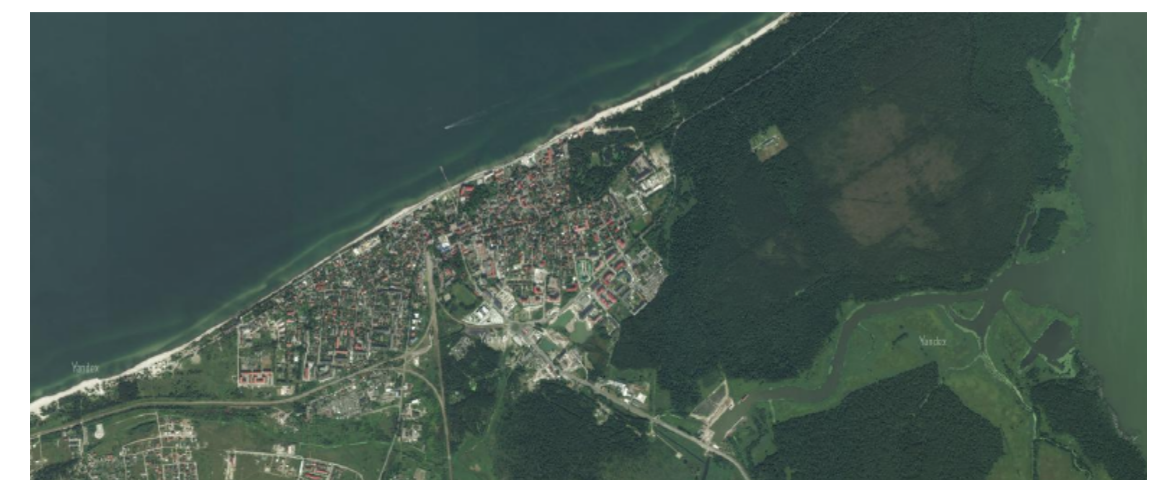

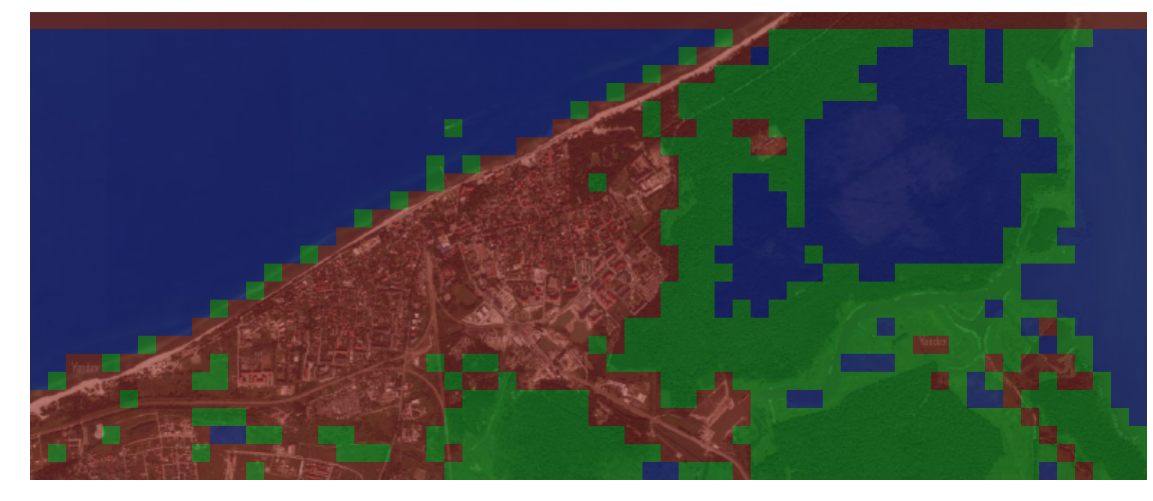

In [15]:
plt.figure(figsize=(20, 10))
plt.imshow(test_image)
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(test_image)
plt.imshow(background_alpha)
plt.axis('off')
plt.show()

# plt.figure(figsize=(20, 10))
# plt.imshow(background)
# plt.axis('off')
# plt.show()

оформим все в виде нескольких функций + усредним результат по сторонам обхода(т е будем выдавать комбинацию RGB)
+ будем обучать по нескольким картинкам (то есть усреднять матрицу переходных вероятностей)

In [16]:
class images_clusterer:
    def __init__(self, images_names, targets_names, box = [25,25], startprob = [1/3, 1/3,1/3]):
        for t in range(len(images_names)):
            image = plt.imread(images_names[t])
            shape = image.shape
            x,y = shape[0],shape[1]
            x = (x//box[0])*box[0]
            y = (y//box[1])*box[1]
            image = image[:x, :y, :]  # обрезка краев, для целочисленного деления
            Y = cut_image(image, box[0], box[1])   # при разбиении на блоки
            
            target = plt.imread(targets_names[t])
            target = target[:x, :y, :]
            target = cut_image(target, box[0], 25)
            clustering(target) 
            X = get_classes(target)

            cur_means, cur_covars = [0,0,0], [0,0,0]
            cur_means[0], cur_covars[0] = est_gauss(Y[X == 0])
            cur_means[1], cur_covars[1] = est_gauss(Y[X == 1])
            cur_means[2], cur_covars[2] = est_gauss(Y[X == 2])

            cur_means = np.array(cur_means)
            cur_covars = np.array(cur_covars)
            
            cur_transmat = np.zeros((3,3))
            for i in range(3):
                for j in range(3):
                    cur_transmat[i, j] = len([X[k] for k in range(len(X)-1) if X[k] == i and X[k+1] == j]) \
                    /len([x for x in X[:-1] if x == i])
            if t == 0:
                transmat = cur_transmat
                means = cur_means
                covars = cur_covars
            else:
                transmat += cur_transmat
                means += cur_means
                covars += cur_covars
        
        means = np.array(means)
        covars = np.array(covars)
        transmat /= len(images_names)
        means /= len(images_names)
        covars /= len(images_names)
        self.model = hmm.GaussianHMM(n_components=3, covariance_type="full")
        self.model.startprob_ = np.array(startprob)
        self.model.transmat_ = transmat
        self.model.means_ = means
        self.model.covars_ = covars     
            
    def build_clustering(self, image_name, box=[25,25]):
        test_image = plt.imread(image_name)
        shape = test_image.shape
        x,y = shape[0],shape[1]
        x = (x//box[0])*box[0]
        y = (y//box[1])*box[1]
        test_image = test_image[:x, :y, :]
        test_Y = cut_image(test_image, x, y)
        # Оценка значений скрытых состояний
        # Может вылететь исключение о вырожденной матрице ковариаций.
        # В таком случае можно матрицу регуляризовать --- добавить к диагональным
        # элементам небольное число так, чтобы детерминант перестал быть слишком маленьким
        predicted = self.model.predict(test_Y)
        
        # Создаем фоновую картинку того же размера
        result = np.zeros_like(test_Y)
        classes = [[1,0,0],[0,1,0],[0,0,1]]
        for i in range(len(result)):
            for j in range(len(result[i])//3):
                cur = classes[predicted[i]] 
                result[i][3*j],result[i][3*j+1],result[i][3*j+2] = cur[0], cur[1], cur[2]

        background = recat_image(result, 
                                 x, y, 3, box[0], box[1])

        # Добавляем к ней 4-й альфа-канал, который отвечает за прозрачность
        background_alpha = np.zeros((background.shape[0], background.shape[1], 4))
        # RGB копируем, сейчас там либо 000, либо 111
        background_alpha[:, :, :3] = background
        # полупрозрачность
        background_alpha[:, :, 3] = 0.5
        return background, background_alpha

In [17]:
%%time
ic = images_clusterer(['train_images/3.png'], ['train_images/3_tr.png'])

CPU times: user 28.3 s, sys: 554 ms, total: 28.9 s
Wall time: 29.8 s


/Users/sergmiller/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [18]:
background, background_alpha = ic.build_clustering('train_images/4.png')

/Users/sergmiller/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ValueError: operands could not be broadcast together with shapes (1,3138750) (1875,) 